# Test of Bayesian Markov-Chain Monte-Carlo Method with ARCS Data

This data was supplied by Garrett Granroth from the SNS / Oak Ridge National Laboratory.

The data reduction was done in Mantid, preserving events, and the events are imported from a nexus autoreduced file.  
As such, the events do have some histogram artefacts from the way that the weights are computed.
I'm not sure if this can be entirely avoided with pixelated detectors, but in an ideal world we'd compute the event weighting factors without using histograms at all.

<>:155: SyntaxWarning: invalid escape sequence '\D'
<>:172: SyntaxWarning: invalid escape sequence '\D'
<>:155: SyntaxWarning: invalid escape sequence '\D'
<>:172: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_1458442/887202551.py:155: SyntaxWarning: invalid escape sequence '\D'
  ema1.plot_kde(log=False, loglog=False, xlabel='$\Delta E$ (meV)')
/tmp/ipykernel_1458442/887202551.py:172: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta$E (meV)')


Loading ESS event mode toolkit (emtk)
Loading curves
Loading omega functions
Loading EventModeAnalyser
/home/19g/vast/science/ZrH2/IPTS-27751/shared/Garrett/201616-exported.nxs
EMAnalyser object created with 5603322 weighted events in range -199.96371 - 600.00006
Calculating KDE
   - linear scale
nx 174
slice size 0.45712214006696433


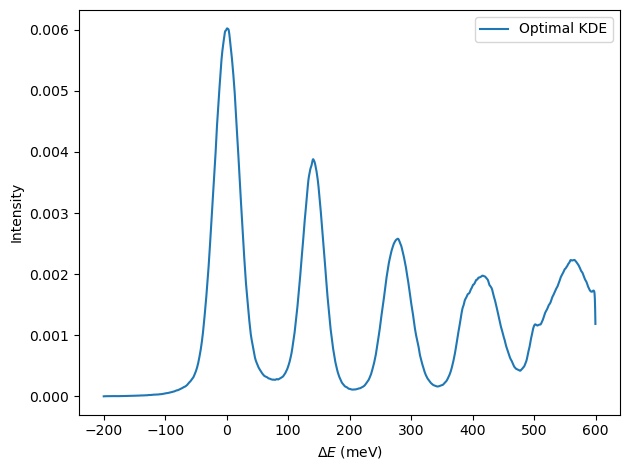

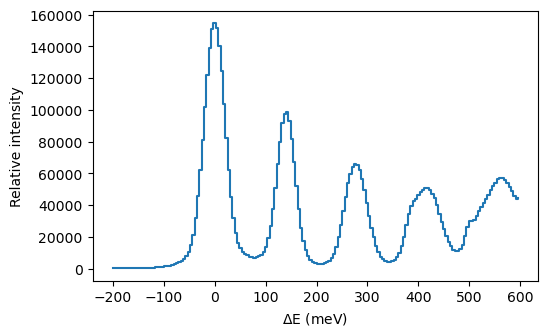

In [1]:
import h5py
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

#import warnings
#warnings.filterwarnings("error")

# Uncomment the following to make random things reproducable
# (useful for paper figures etc)
# In theory this should work, but for some reason the later analyses are shifting around

RANDOM_SEED = 0
np.random.seed(seed=RANDOM_SEED)

import lmfit 

from scipy.stats import cauchy
from scipy.stats import norm
from scipy.stats import uniform

import copy


import emtk.EventModeAnalyser.EMAnalyser as ema

# During development, importlib lets us change the source and force reload of the emtk package.
# However, whilst the error reporting line number is right, the printout of
# the offending source code is stuck to the first import.  Just so you know...
import importlib
importlib.reload(ema) 

def loadRawARCS(number):
    ldpath="/Users/phillipbentley/Code/python/mle/data/SNS/ARCS/ZrH2/IPTS-27751/nexus"
    stem="/ARCS_"
    tail=".nxs.h5"

    filename = ldpath + stem + str(number) + tail

    print(filename)

    f = h5py.File(filename, 'r')

    print( list(f.keys()) )

    entr = f['entry']
    b30 = entr['bank30_events']

    
    print( b30 )
    print( list(b30.keys()) )

    print(b30['event_id'])

    f.close()


def listkeys(obj):
    print( list( obj.keys()) )

def loadARCSmd(number,ldpath="/home/19g/vast/science/ZrH2/IPTS-27751/shared/Garrett/"):
    
    tail="-exported.nxs"

    filename = ldpath + str(number) + tail

    print(filename)

    f = h5py.File(filename, 'r')
    ws = f['MDEventWorkspace']
    cs = ws['coordinate_system']
    ed = ws['event_data']['event_data']
    bs = ws['box_structure']
    ex = ws['experiment0']
    pr = ws['process']
    vn = ws['visual_normalization']

    #for i in range(7):
    #    ed1 = ed[:,i]
    #    fig,ax = plt.subplots()
    #    plt.plot(ed1)

    dE = ed[:,6]
    wt = ed[:,0]

    #fig,ax = plt.subplots()
    #plt.plot(dE, wt)

    # Filter out zeros

    mask = wt > 0.0

    keepdE = dE[mask]
    keepwt = wt[mask]

    return keepdE, keepwt







""" We might need an integral function between two points (xmin, xmax) 
for every term in the fitting function, so that the relative likelihoods are 
normalised within the data bounds.  It will be good to check whether these
are actually needed or not in the final analysis, but in previous work
these proved to be necessary.
"""

def cauchy_integral(x1, x2, kappa):
    # Returns the integral of a cauchy distribution between two x values

    if x1 < x2:
        xmin = x1
        xmax = x2
    else:
        xmin = x2
        xmax = x1

    
    t1 = np.arctan(xmax/kappa)
    t2 = np.arctan(xmin/kappa)
    
    return (t1 - t2)/np.pi

    

def uniform_integral(x1, x2):
    # Returns the integral of a uniform distribution between two x values

    if(x1 == x2):
        return 0.0

    return np.absolute(x1-x2)



def gaussian_integral(x1, x2, mu=0.0, sigma=1.0):
    # Integral of a gaussian curve between two points
    t1 = norm.cdf(x1, loc=mu, scale=sigma)
    t2 = norm.cdf(x2, loc=mu, scale=sigma)
    intg = t1 - t2

    return np.absolute(intg)




evs, wts = loadARCSmd(201616)

ema1 = ema.EMAnalyser(evs, wts)

# We need a full data KDE for later...
ema1.plot_kde(log=False, loglog=False, xlabel='$\Delta E$ (meV)')

#ema1.plot_histogram(loglog=False, log=False, xlabel='meV')

# Manually replot and save histo figure for a paper
bn=ema1.optimal_n_bins()
hst = np.histogram(ema1.data, bins=bn, weights=ema1.weights)
hx=hst[1]
hy=hst[0]
# wipe over zero value artefacts
zind = np.where(hy==0.0)
for i in range(0, hx.size):
    if i > 0 and np.isin(i, zind):
        hy[i] = hy[i-1]
hx = hx[:-1]
fig,ax=plt.subplots()
ax.step(hx, hy, where='post')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
#plt.savefig('arcsFigs/arcs_data_histo.png', dpi=600, bbox_inches='tight')
plt.show()


<>:88: SyntaxWarning: invalid escape sequence '\D'
<>:88: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_1458442/2260100434.py:88: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta$E (meV)')


Least squares model function defined.
['amplitude', 'elmu', 'mu1', 'mu2', 'mu3', 'mu4', 'mubg1', 'mubg2', 'elsigma', 's1', 's2', 's3', 's4', 'sbg1', 'sbg2', 'm1', 'm2', 'm3', 'm4', 'mbg1', 'mbg2']
[ 1.01044970e+00 -2.44065648e+00  1.38398420e+02  2.75335927e+02
  4.09661086e+02  5.59543370e+02  6.67814934e+02  6.08387853e+01
  1.99047883e+01  1.75257700e+01  2.17808406e+01  2.84924149e+01
  4.60507084e+01  1.00302401e+02  9.42264819e+01  2.89806797e-01
  1.61374552e-01  1.38491992e-01  1.44213763e-01  2.00463333e-01
  1.60648161e-11]
[3.42536654e-03 1.10409912e-01 1.52786941e-01 2.47379023e-01
 8.29951779e-01 9.39739168e+00 2.65052378e+10 1.30280632e+01
 1.40451128e-01 2.08589481e-01 2.73813734e-01 1.00019562e+00
 1.02404128e+01 1.51786596e+12 1.04057550e+01 3.12732179e-03
 2.59653465e-03 1.77955647e-03 1.19314250e-02 1.11921032e-01
 6.09584257e+00]


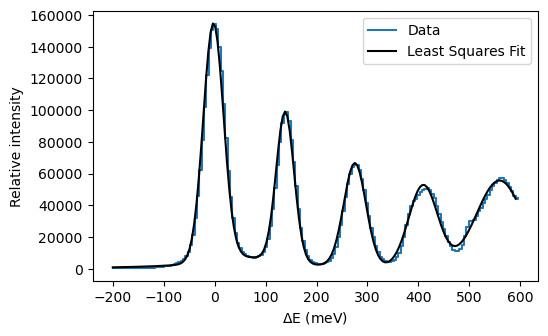

In [2]:
def big_lse_pdf(x, amplitude, elmu, mu1, mu2, mu3, mu4, mubg1, mubg2, elsigma, s1, s2, s3, s4, sbg1, sbg2, m1, m2, m3, m4, mbg1, mbg2):
    
    mvals = ema1.simplex_weights(np.array([m1, m2, m3, m4, mbg1, mbg2]))

    el = mvals[0] * norm.pdf(x, scale=elsigma, loc=elmu) / gaussian_integral(ema1.xmin, ema1.xmax, elsigma)

    l1 = mvals[1] * norm.pdf(x, scale=s1, loc=mu1) / gaussian_integral(ema1.xmin, ema1.xmax, mu1, s1)
    l2 = mvals[2] * norm.pdf(x, scale=s2, loc=mu2) / gaussian_integral(ema1.xmin, ema1.xmax, mu2, s2)
    l3 = mvals[3] * norm.pdf(x, scale=s3, loc=mu3) / gaussian_integral(ema1.xmin, ema1.xmax, mu3, s3)
    l4 = mvals[4] * norm.pdf(x, scale=s4, loc=mu4) / gaussian_integral(ema1.xmin, ema1.xmax, mu4, s4)
    bg1= mvals[5] * norm.pdf(x, scale=sbg1, loc=mubg1) / gaussian_integral(ema1.xmin, ema1.xmax, mubg1, sbg1)
    bg2= mvals[6] * cauchy.pdf(x, scale=sbg2, loc=mubg2) / cauchy_integral(ema1.xmin, ema1.xmax, sbg2)
    
    sol = amplitude * (el + l1 + l2 + l3 + l4 + bg1 + bg2)
    
    return sol


ema1.set_lse_function(big_lse_pdf)


ema1.make_lse_params(
    amplitude=dict(value=1.0, min=0.0),\
    elmu = dict(value=0.0, min=-100.0, max=100.0),\
    mu1 = dict(value=150.0, min=100.0, max=200.0),\
    mu2 = dict(value=280.0, min=200.0, max=350.0),\
    mu3 = dict(value=420.0, min=350.0, max=450.0),\
    mu4 = dict(value=560.0, min=500.0, max=620.0),\
    mubg1=dict(value=620.0, min=600.0, max=700.0),\
    mubg2=dict(value=140.0, min=0.0, max=200.0),\

    elsigma = dict(value=20.0, min=10.0, max=100.0),\
    s1 = dict(value=30.0, min=10.0, max=100.0),\
    s2 = dict(value=30.0, min=10.0, max=100.0),\
    s3 = dict(value=30.0, min=10.0, max=100.0),\
    s4 = dict(value=30.0, min=10.0, max=100.0),\
    sbg1=dict(value=100.0, min=100.0, max=250.0),\
    sbg2=dict(value=20.0, min=10.0, max=250.0),\
    m1=dict(value=0.3, min=0.0, max = 1.0),\
    m2=dict(value=0.2, min=0.0, max = 1.0),\
    m3=dict(value=0.15, min=0.0, max = 1.0),\
    m4=dict(value=0.1, min=0.0, max = 1.0),\
    mbg1=dict(value=0.1, min=0.0, max=1.0),\
    mbg2=dict(value=0.1, min=0.0, max=1.0)
)

lse_starting_parameters = copy.deepcopy(ema1.least_squares_parameters)

#ema1.plot_LSE_initial(loglog=False, log=False)

ema1.lse_fit()
#ema1.plot_LSE_fit(loglog=False, log=False, xlabel='meV', save="/Users/phillipbentley/Code/python/mle/arcs_lse_fit.png")

pnams = ema1.get_lse_param_names()
print(pnams)

pvals = ema1.get_lse_param_values()
print(pvals)

detailed_fit_params = pvals

psigs = ema1.get_lse_param_errors()
print(psigs)

detailed_fit_sigmas = psigs

# Manually replot and save figure for a paper
bn=ema1.optimal_n_bins()
hst = np.histogram(ema1.data, bins=bn, weights=ema1.weights)
hx=hst[1]
hy=hst[0]
# wipe over zero value artefacts
zind = np.where(hy==0.0)
for i in range(0, hx.size):
    if i > 0 and np.isin(i, zind):
        hy[i] = hy[i-1]
hx = hx[:-1]
fig,ax=plt.subplots()
ax.step(hx, hy, where='post', label='Data')
nhy = hy.size
shy = np.sum(hy)
nly = ema1.lse_result.best_fit.size
sly = np.sum(ema1.lse_result.best_fit)

scl = shy * nly / (nhy * sly)

ax.plot(ema1.histx, scl*ema1.lse_result.best_fit, color='black', label='Least Squares Fit')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
plt.legend()
#plt.savefig('arcsFigs/arcs_data_lse.png', dpi=600, bbox_inches='tight')
plt.show()


In [3]:
ema1.lse_result

In [4]:
cpo=ema1.subsample(30000)
cpo.lse_result= copy.deepcopy(ema1.lse_result)

In [5]:
cpo.lse_result

<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:26: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:26: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_1458442/1217488537.py:18: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta$E (meV)')
/tmp/ipykernel_1458442/1217488537.py:26: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta$E (meV)')


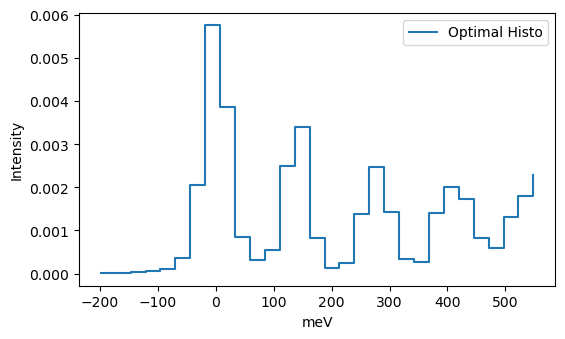

Calculating KDE
   - linear scale
nx 30
slice size 2.57608150359123


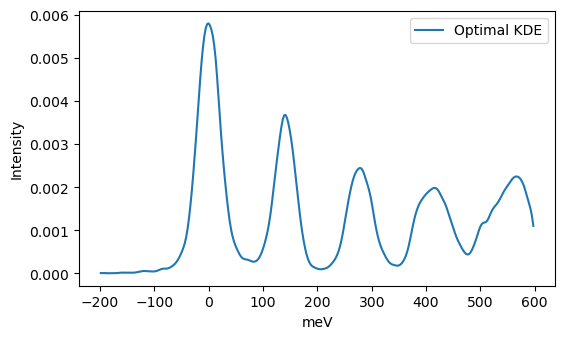

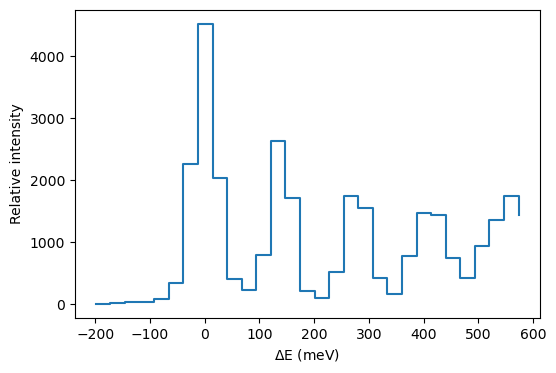

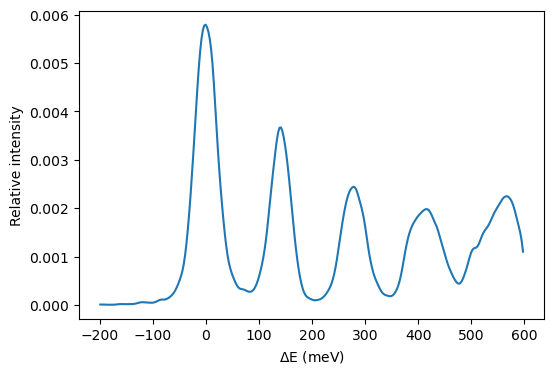

In [6]:
#cpo = ema1.subsample(30000)
cpo.plot_histogram(loglog=False,log=False, xlabel='meV')
cpo.plot_kde(loglog=False,log=False, xlabel='meV', method='fdr')

# Manually replot and save figure for a paper
bn=cpo.optimal_n_bins()
hst = np.histogram(cpo.data, bins=bn, weights=cpo.weights)
hx=hst[1]
hy=hst[0]
# wipe over zero value artefacts
zind = np.where(hy==0.0)
for i in range(0, hx.size):
    if i > 0 and np.isin(i, zind):
        hy[i] = hy[i-1]
hx = hx[:-1]
fig,ax=plt.subplots()
ax.step(hx, hy, where='post')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
fig.set_size_inches(6,4)
#plt.savefig('arcsFigs/arcs_data_subsampled_histo.png', dpi=600, bbox_inches='tight')
plt.show()

fig,ax=plt.subplots()
plt.plot(cpo.kdex, cpo.kdey)
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
fig.set_size_inches(6,4)
#plt.savefig('arcsFigs/arcs_data_subsampled_kde.png', dpi=600, bbox_inches='tight')
plt.show()

In [7]:
# Build MCMC Models with API

def simplex_weights(Qraw: np.ndarray) -> np.ndarray:
    # Raw Q values can run between 0-1 to keep things simple
    # The sum is assumed to be 1, preventing out of gamut values
    # That condition is enforced already in the last 4 terms of 
    # the log_prior above.
    # Note that Qraw has one dimension fewer
    # than the number of parameters, like this:
    # https://en.m.wikipedia.org/wiki/Ternary_plot
    
    Qraw = np.asarray(Qraw)
    
    Qsum = np.sum(Qraw)    
    Qlast = 1.0 - Qsum
    
    Qvals = np.append(Qraw, Qlast)
    return Qvals

def log_prior_function(theta):
    # The main role of this function is to set 
    # parameter bounds of the bayesian search space
    elmu, mu1, mu2, mu3, mu4, mubg1, mubg2, elsigma, s1, s2, s3, s4, sbg1, sbg2, m1, m2, m3, m4, mbg1, mbg2 = theta

    if -70.0 < elmu < 100.0 and \
        100.0 < mu1  < 200.0 and \
        200.0 < mu2  < 350.0 and \
        350.0 < mu3  < 450.0 and \
        500.0 < mu4  < 620.0 and \
        600.0 < mubg1< 700.0 and \
        0.0   < mubg2< 200.0 and \
        10.0 < elsigma < 100.0 and \
        10.0 < s1 < 100.0 and \
        10.0 < s2 < 100.0 and \
        10.0 < s3 < 100.0 and \
        10.0 < s4 < 100.0 and \
        100.0 < sbg1 < 250.0 and \
        10.0  < sbg2 < 250.0 and \
        0.1 < m1 < 1.0 and\
        0.1 < m2 < 1.0 and\
        0.1 < m3 < 1.0 and\
        0.1 < m4 < 1.0 and\
        0.1 < mbg1 < 1.0 and\
        0.1 < mbg2 < 1.0 and\
        m1 + m2 + m3 + m4 + mbg1 + mbg2 < 1.0:
        return 0.0
    
    return -np.inf



def probability_mass_function(theta, xx, xmin, xmax, pweights, verbose=False):
    
    elmu, mu1, mu2, mu3, mu4, mubg1, mubg2, elsigma, s1, s2, s3, s4, sbg1, sbg2, m1, m2, m3, m4, mbg1, mbg2 = theta

    pweights = np.asarray(pweights)
    
    if (pweights==None).any():
        use_weights = np.ones_like(xx)
    else:
        use_weights = pweights

    spscale = xmax-xmin


    mvals = simplex_weights(np.array([m1, m2, m3, m4, mbg1, mbg2]))

    el = mvals[0] * norm.pdf(xx, scale=elsigma, loc=elmu) / gaussian_integral(ema1.xmin, ema1.xmax, elsigma)

    l1 = mvals[1] * norm.pdf(xx, scale=s1, loc=mu1) / gaussian_integral(ema1.xmin, ema1.xmax, mu1, s1)
    l2 = mvals[2] * norm.pdf(xx, scale=s2, loc=mu2) / gaussian_integral(ema1.xmin, ema1.xmax, mu2, s2)
    l3 = mvals[3] * norm.pdf(xx, scale=s3, loc=mu3) / gaussian_integral(ema1.xmin, ema1.xmax, mu3, s3)
    l4 = mvals[4] * norm.pdf(xx, scale=s4, loc=mu4) / gaussian_integral(ema1.xmin, ema1.xmax, mu4, s4)
    bg1= mvals[5] * norm.pdf(xx, scale=sbg1, loc=mubg1) / gaussian_integral(ema1.xmin, ema1.xmax, mubg1, sbg1)
    bg2= mvals[6] * cauchy.pdf(xx, scale=sbg2, loc=mubg2) / cauchy_integral(ema1.xmin, ema1.xmax, sbg2)

    
    sol = (el + l1 + l2 + l3 + l4 + bg1 + bg2)**use_weights
    
    return sol



def log_likelihood_function(theta, data, xmin, xmax, pweights, mylpf, verbose=False):

    raiseError = False
    result = 0.0

    elmu, mu1, mu2, mu3, mu4, mubg1, mubg2, elsigma, s1, s2, s3, s4, sbg1, sbg2, m1, m2, m3, m4, mbg1, mbg2 = theta

    pweights = np.asarray(pweights)
    
    if (pweights==None).any():
        use_weights = np.ones_like(data)
    else:
        use_weights = pweights
        
    
    lp = mylpf(theta)
    
    if np.isinf(lp):
        return -np.inf

    mvals = simplex_weights(np.array([m1, m2, m3, m4, mbg1, mbg2]))
    


    el = mvals[0] * norm.pdf(data, scale=elsigma, loc=elmu) / gaussian_integral(ema1.xmin, ema1.xmax, elsigma)
    l1 = mvals[1] * norm.pdf(data, scale=s1, loc=mu1) / gaussian_integral(ema1.xmin, ema1.xmax, mu1, s1)
    l2 = mvals[2] * norm.pdf(data, scale=s2, loc=mu2) / gaussian_integral(ema1.xmin, ema1.xmax, mu2, s2)
    l3 = mvals[3] * norm.pdf(data, scale=s3, loc=mu3) / gaussian_integral(ema1.xmin, ema1.xmax, mu3, s3)
    l4 = mvals[4] * norm.pdf(data, scale=s4, loc=mu4) / gaussian_integral(ema1.xmin, ema1.xmax, mu4, s4)
    bg1= mvals[5] * norm.pdf(data, scale=sbg1, loc=mubg1) / gaussian_integral(ema1.xmin, ema1.xmax, mubg1, sbg1)
    bg2= mvals[6] * cauchy.pdf(data, scale=sbg2, loc=mubg2) / cauchy_integral(ema1.xmin, ema1.xmax, sbg2)


    # Guard against zero values in each term
    minval = 1.0E-300

    msk = el < minval
    el[msk] = minval

    msk = l1 < minval
    l1[msk] = minval

    msk = l2 < minval
    l2[msk] = minval

    msk = l3 < minval
    l3[msk] = minval

    msk = l4 < minval
    l4[msk] = minval

    msk = bg1 < minval
    bg1[msk] = minval

    msk = bg2 < minval
    bg2[msk] = minval

    
 #   try:
    lel = np.log(el)
    ll1 = np.log(l1)
    ll2 = np.log(l2)
    ll3 = np.log(l3)
    ll4 = np.log(l4)
    lbg1 = np.log(bg1)
    lbg2 = np.log(bg2)

    lt1 = np.logaddexp(lel, ll1)
    lt2 = np.logaddexp(lt1, ll2)
    lt3 = np.logaddexp(lt2, ll3)
    lt4 = np.logaddexp(lt3, ll4)
    lt5 = np.logaddexp(lt4, lbg1)
    lt6 = np.logaddexp(lt5, lbg2)

    lll = np.sum(lt6 * use_weights)
    
    result = lp + lll

    if np.isnan(result):
        print("NaN in log_likelihood at", theta)
        verbose=True
                    
    if verbose==True:
        print("lp", lp)
        print("lll", lll)
        print("l1", l1)
        print("l2", l2)
        print("l3", l3)
        print("l4", l4)
        print("bg1", bg1)
        print("bg2", bg2)
        print("")
        print("m0", mvals[0])
        print("m1", mvals[1])
        print("m2", mvals[2])
        print("m3", mvals[3])
        print("m4", mvals[4])
        print("m5", mvals[5])
        print("m6", mvals[6])

    return result

    
#   except RuntimeWarning as e:
#        print("Runtime warning at", theta)
#        print(e)
#        raise
    


cpo.lpf = log_prior_function
cpo.pmf = probability_mass_function
cpo.llf = log_likelihood_function

# Seed MCMC search manually
# ema1.make_lse_params(
#    amplitude=dict(value=1.0, min=0.0),\
#    elmu = dict(value=10.0, min=-100.0, max=100.0),\
#    mu1 = dict(value=150.0, min=100.0, max=200.0),\
#    mu2 = dict(value=280.0, min=200.0, max=350.0),\
#    mu3 = dict(value=420.0, min=350.0, max=450.0),\
#    mu4 = dict(value=560.0, min=500.0, max=620.0),\
#    mubg1=dict(value=620.0, min=600.0, max=700.0),\
#    mubg2=dict(value=140.0, min=0.0, max=200.0),\

#    elsigma = dict(value=20.0, min=10.0, max=100.0),\
#    s1 = dict(value=30.0, min=10.0, max=100.0),\
#    s2 = dict(value=30.0, min=10.0, max=100.0),\
#    s3 = dict(value=30.0, min=10.0, max=100.0),\
#    s4 = dict(value=30.0, min=10.0, max=100.0),\
#    sbg1=dict(value=100.0, min=100.0, max=250.0),\
#    sbg2=dict(value=20.0, min=10.0, max=250.0),\
#    m1=dict(value=0.3, min=0.0, max = 1.0),\
#    m2=dict(value=0.2, min=0.0, max = 1.0),\
#    m3=dict(value=0.15, min=0.0, max = 1.0),\
#    m4=dict(value=0.1, min=0.0, max = 1.0),\
#    mbg1=dict(value=0.1, min=0.0, max=1.0),\
#    mbg2=dict(value=0.1, min=0.0, max=1.0)
#)

same_as_least_squares = np.array([0.0, 150.0, 280.0, 420.0, 560.0,\
                                 620.0, 140.0, 20.0, 30.0, 30.0,\
                                 30.0, 30.0, 100.0, 20.0,\
                                 0.3, 0.2, 0.15, 0.1, 0.1, 0.1])

#cpo.theta_seed = np.array([7.83319976e+00, 1.45695047e+02, 2.81254328e+02,\
# 4.14035526e+02, 5.52327378e+02, 6.99999691e+02, 2.30190791e-02,\
# 1.86422670e+01, 1.99165093e+01, 2.21066916e+01, 2.75136714e+01,\
# 2.79613790e+01, 1.16801601e+02, 4.02817313e+01, 1.90420268e-01,\
# 1.40207127e-01, 1.18191129e-01, 1.18351136e-01, 7.89817013e-02,\
# 2.74781599e-01])

nan_location = np.array([9.99999112e+00, 1.49999991e+02, 2.80000003e+02, 4.20000001e+02,\
 5.60000002e+02, 6.20000016e+02, 1.39999999e+02, 2.00000157e+01,\
 2.99999882e+01, 3.00000001e+01, 3.00000015e+01, 3.00000010e+01,\
 1.00000001e+02, 2.00000099e+01, 2.99987259e-01, 2.00008231e-01,\
 1.50005576e-01, 1.00000433e-01, 1.00000804e-01, 1.00002444e-01])

cpo.theta_seed = same_as_least_squares

# Seed MCMC search with LSE fit
#cpo.lse_fit()
#cpo.theta_seed = detailed_fit_params # <- this takes parameters from the detailed fit done earlier
#cpo.theta_seed = cpo.theta_seed[1:]

#log_likelihood_function(theta, data, xmin, xmax, pweights, mylpf, verbose=False)
#test=log_likelihood_function(nan_location, ema1.data, np.amin(ema1.data), np.amax(ema1.data), ema1.weights, log_prior_function, verbose=True)

cpo.nwalkers=32 # need to increase this to improve sampling stats quality 
# (see plots of MCMC_parameter_distribution later) 

cpo.MCMC_fit(nburn=150, niter=150) # fixed number of iterations
#cpo.MCMC_fit(niter=5000, convergence="Gelman-Rubin") # gelman-rubin method to check for convergence


MCMC launch
Burn in:


  0%|          | 0/150 [00:00<?, ?it/s]/home/19g/miniforge3/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 150/150 [00:48<00:00,  3.10it/s]


Sampling:


100%|██████████| 150/150 [00:55<00:00,  2.71it/s]

MCMC sampling complete.


(150, 41, 20)
(150, 41, 20)


True

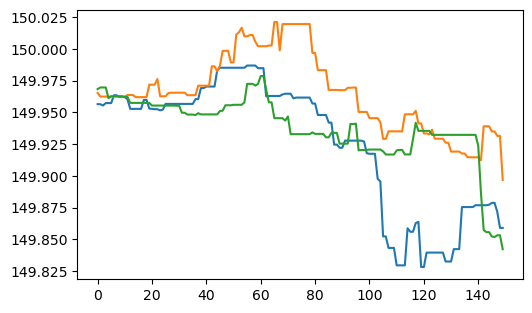

In [8]:
chz = cpo.sampler.get_chain()
nwk = cpo.nwalkers
ndm = cpo.ndim

rlen = chz.shape[0]

print(chz.shape)

burned = chz[-1000::]
#=np.delete(chz, np.s_[rlen-42:rlen], axis=0)
print(burned.shape)
ch1 = burned[:,1,1]
ch2 = burned[:,2,1]
ch3 = burned[:,3,1]
fig,ax=plt.subplots()
ax.plot(ch1)
ax.plot(ch2)
ax.plot(ch3)

cpo.self_check()

In [9]:
# The standard deviation is the square root of the variance.
# Therefore, the variance should be the standard deviation squared.

chz = cpo.sampler.get_chain()
nw = float(cpo.nwalkers)
nd = float(cpo.ndim)
ns = float(chz.shape[0])

print(chz.shape)

mns = np.mean(chz, axis=0)
print("mean shape", mns.shape)
gmn = np.mean(mns, axis=0)
print("gmn  shape", gmn.shape)


wch_variance = 1.0 / (ns - 1.0) * np.sum( (chz - mns)**2.0, axis=0)
print("wchv shape", wch_variance.shape)
wch_var_alt = np.std(chz, axis=0)**2.0
print("w alt shape", wch_var_alt.shape)


bch_variance = ns/(nw - 1.0) * np.sum( (mns - gmn)**2.0, axis=0)
print("bchv shape", bch_variance.shape)

print(bch_variance)

bch_alt_variance = np.std(mns, axis=0)**2.0
print("b alt shape", bch_alt_variance.shape)
print(bch_alt_variance)


ww = (1.0 / nw) * np.sum(wch_variance, axis=0)

wwalt = np.mean(wch_var_alt, axis=0)

print("ww shape", ww.shape)
print("wwalt sh", wwalt.shape)

print("ww", ww)
print("wwalt", wwalt)

t1 = (ns-1.0)*ww / ns
t2 = bch_variance / ns

t1alt = (ns-1.0) * wwalt / ns
t2alt = (bch_alt_variance)

print("t1 shape", t1.shape)
print("t2 shape", t2.shape)

grstat = (t1 + t2) / ww
print(grstat)

gralt = (t1alt + t2alt) / wwalt
print(gralt)


(150, 41, 20)
mean shape (41, 20)
gmn  shape (20,)
wchv shape (41, 20)
w alt shape (41, 20)
bchv shape (20,)
[0.10093595 0.04328928 0.2018986  0.11239162 0.05808131 0.12591307
 0.03599689 0.15128304 0.74245395 0.04979056 0.22307426 0.31466353
 0.24456502 0.19485887 0.00333226 0.00167535 0.0013808  0.0012605
 0.00098709 0.00200978]
b alt shape (20,)
[6.56494002e-04 2.81556309e-04 1.31316162e-03 7.31002418e-04
 3.77764612e-04 8.18946768e-04 2.34126114e-04 9.83954726e-04
 4.82896881e-03 3.23841065e-04 1.45088946e-03 2.04659203e-03
 1.59066678e-03 1.26737473e-03 2.16732396e-05 1.08966009e-05
 8.98083979e-06 8.19836481e-06 6.42010968e-06 1.30717688e-05]
ww shape (20,)
wwalt sh (20,)
ww [5.46907306e-03 1.03865033e-03 7.35667108e-03 2.19397963e-03
 1.12650330e-03 3.45109655e-03 8.05455872e-04 7.43399508e-03
 1.31460658e-02 2.22771163e-03 7.35210941e-03 5.32226650e-03
 1.08139480e-02 4.16766663e-03 3.23167965e-05 2.05101288e-04
 2.13428517e-05 1.27102006e-05 1.98331163e-05 3.78625725e-05]
wwal

In [10]:
def gsdev(mcmcObject, burn=50) -> np.ndarray :

        # Something is a bit wrong with this.
        # The statistic is starting out at a value of 2
        # in the ARCS test notebook and gently increasing
        # It should not be behaving in this way, there is obviously
        # a mistake in the maths below...

        chains = mcmcObject.sampler.get_chain(discard=burn)
            
        nwk = mcmcObject.nwalkers # "J"
        ndm = mcmcObject.ndim
        nsamps = chains.shape[0] #"L"

        chain_mean = np.mean(chains, axis=0)        
        grand_mean = np.mean(chain_mean, axis=0)

        within_chain_variance = 1.0 / (nsamps - 1.0) * np.sum( (chains - grand_mean)**2.0, axis=0)
        between_chain_variance = nsamps/(nwk - 1.0) * np.sum( (chain_mean - grand_mean)**2.0, axis=0)
        
        ww = (1.0 / nwk) * np.sum(within_chain_variance, axis=0)
        
        t1 = (nsamps-1.0)*ww / nsamps
        t2 = between_chain_variance / nsamps
        
        grstat = (t1 + t2) / ww
        
        return grstat

gs0 = gsdev(cpo, burn=0)
gs10 = gsdev(cpo, burn=10)
gs50 = gsdev(cpo, burn=50)
gs100= gsdev(cpo, burn=100)
gs150= gsdev(cpo, burn=150)

print(gs0)
print(gs10)
print(gs50)
print(gs100)
print(gs150)

[1.10310647 1.21161941 1.14842558 1.2490692  1.25030698 1.18966421
 1.22382702 1.1130493  1.26820261 1.12331481 1.16208474 1.27748235
 1.12465797 1.23197535 1.40369387 1.04502474 1.29630105 1.39418666
 1.24358181 1.25593661]
[1.11943437 1.22942184 1.1644827  1.26906959 1.28454012 1.22031111
 1.25355296 1.13314769 1.29597037 1.14047023 1.18133938 1.29665445
 1.13994113 1.25161447 1.43439788 1.0577681  1.30963497 1.42907647
 1.27739478 1.2867193 ]
[1.27641011 1.31007199 1.30535308 1.35778656 1.42750235 1.38409568
 1.37003903 1.23404541 1.41473959 1.27775709 1.30135396 1.39240828
 1.28009552 1.36309335 1.50435969 1.13337577 1.43795505 1.48712605
 1.40219602 1.45126584]
[1.54999469 1.60855319 1.61224109 1.64930859 1.66472635 1.63356233
 1.6431173  1.57734038 1.65484635 1.61208425 1.62944942 1.66153852
 1.56655411 1.65788113 1.66281381 1.45013016 1.55703944 1.67194781
 1.65564137 1.69359652]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]


/home/19g/miniforge3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/19g/miniforge3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_1458442/3420626334.py:23: RuntimeWarning: invalid value encountered in divide
  t1 = (nsamps-1.0)*ww / nsamps


<>:30: SyntaxWarning: invalid escape sequence '\D'
<>:61: SyntaxWarning: invalid escape sequence '\D'
<>:30: SyntaxWarning: invalid escape sequence '\D'
<>:61: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_1458442/3456411472.py:30: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta$E (meV)')
/tmp/ipykernel_1458442/3456411472.py:61: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta$E (meV)')


Calculating KDE
   - linear scale
nx 30
slice size 2.57608150359123


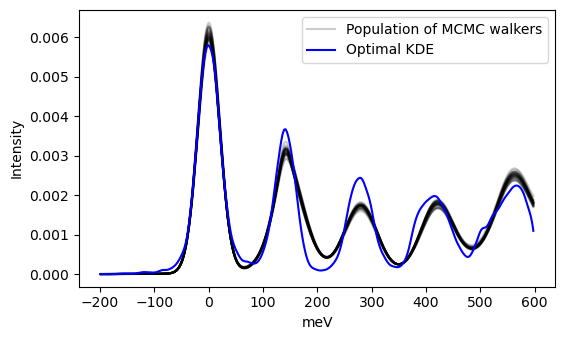

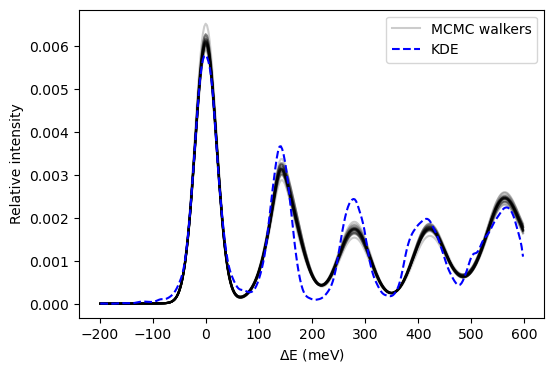

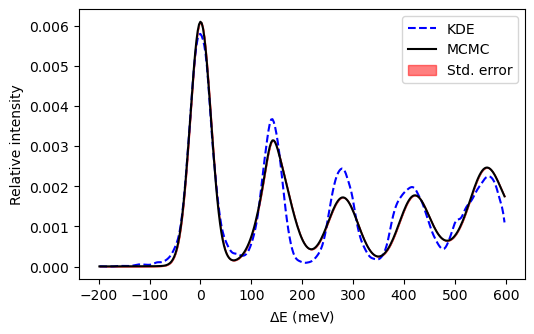

In [11]:
#cpo.plot_LSE_fit(loglog=False, log=False, xlabel='meV')
#cpo.plot_MCMC_fit(method="histo", loglog=False, log=False, xlabel='meV', save="arcs_mcmc_fit.png")

cpo.self_check()

cpo.plot_MCMC_fit(method='kde', loglog=False, log=False, xlabel='meV')
#cpo.plot_MCMC_fit(method='histo', loglog=False, log=False, xlabel='meV')

# Repeat plot manually for paper output

flt = cpo.sampler.get_chain(discard=20, thin=15, flat=True)
inds  = np.random.choice(len(flt), size=30, replace=False)
pt_sum = np.sum(cpo.kdey)

fig,ax=plt.subplots()

for ind in inds:
    smp = flt[ind]
    yfit = cpo.pmf(smp, cpo.kdex, cpo.xmin, cpo.xmax, None)
    ysum = np.sum(yfit)
    scale = pt_sum / ysum
    yfit = yfit * scale

    if ind == inds[0]:
        ax.plot(cpo.kdex, yfit, color='black', alpha=0.2, label='MCMC walkers')
    else:
        ax.plot(cpo.kdex, yfit, color='black', alpha=0.2)

plt.plot(cpo.kdex, cpo.kdey, ls='--', color='blue', label='KDE')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
#plt.xlim([410, 435])
#plt.ylim([0.0014, 0.00195])
plt.legend()
fig.set_size_inches(6,4)
#plt.savefig('arcsFigs/arcs_data_subsampled_kde_fit.png', dpi=600, bbox_inches='tight')
plt.show()

# Plot showing the average of the PDFs over all walkers?
inds = np.arange(len(flt))

yfit = np.zeros((len(inds),cpo.kdex.size))

for ind in inds:
    smp = flt[ind]
    yfit[ind] = cpo.pmf(smp, cpo.kdex, cpo.xmin, cpo.xmax, None)

ymean = np.mean(yfit, axis=0)
ystd = np.std(yfit, axis=0)
ystd = ystd / np.sqrt(len(inds))

                
ysum = np.sum(ymean)
scale = pt_sum / ysum
ymean = ymean * scale
ystd = ystd * scale

plt.plot(cpo.kdex, cpo.kdey, ls='--', color='blue', label='KDE')
plt.plot(cpo.kdex, ymean, color='black', label='MCMC')
plt.fill_between(cpo.kdex, ymean-ystd, ymean+ystd, color='red', alpha=0.5, label='Std. error')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
#plt.xlim([410, 435])
#plt.ylim([0.0014, 0.00195])
plt.legend()
fig.set_size_inches(6,4)
#plt.savefig('arcsFigs/arcs_data_subsampled_kde_fit_mean.png', dpi=600, bbox_inches='tight')
plt.show()

stdd 0.07803272760404657
stdd 0.03623923712055245
stdd 0.09284819990969069
stdd 0.05394771093674983
stdd 0.038687955345486996
stdd 0.06516928729033916
stdd 0.032159171013889785
stdd 0.09147890379434626
stdd 0.13374376293445414
stdd 0.050365675656790294
stdd 0.09356273196359714
stdd 0.08563513741561188
stdd 0.11105188780886979
stdd 0.07353405277307014
stdd 0.007333116034075643
stdd 0.014650274636203048
stdd 0.005493760623717803
stdd 0.0045633135715273734
stdd 0.00511087128083791
stdd 0.007119123829604137
149.93444204368834 +/- 0.000462105873744895 using method mean


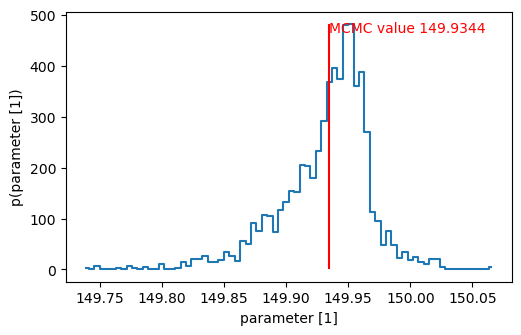

fwhm 3.4291060827669275
fwhm 9.04102564102564
fwhm 4.192264286447113
fwhm 12.325874867444327
fwhm 8.35473497449545
fwhm 5.071350336410582
fwhm 10.750163826998687
fwhm 6.404456193353474
fwhm 3.803711176326729
fwhm 4.063967213114751
fwhm 5.712904911180772
fwhm 10.958194536975341
fwhm 2.232852245367947
fwhm 7.906671048307594
fwhm 13.54732142857143
fwhm 7.487499999999999
fwhm 12.758214285714285
fwhm 13.255444646098002
fwhm 4.247518610421837
fwhm 1.629270780214176
149.95206640944633 +/- 0.06787000414885976 using method peak


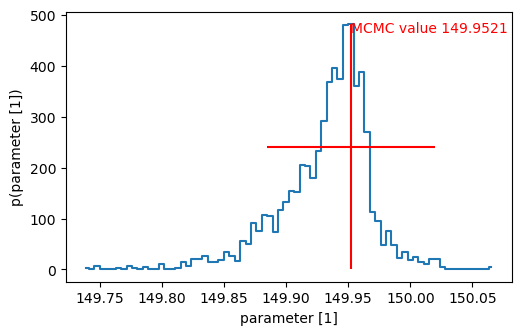

In [12]:
lookat=1
#cpo.plot_MCMC_parameter_distribution(lookat, compare=True)
cpo.plot_MCMC_parameter_distribution(lookat, compare=False, method='mean', savename='arcsFigs/arcs_parameter_mean.png')
cpo.plot_MCMC_parameter_distribution(lookat, compare=False, method='peak', savename='arcsFigs/arcs_parameter_peak.png')


In [13]:
print("PEAK METHOD:")
mcpparams, mcperr = cpo.get_MCMC_parameters(method='peak')
print(mcpparams)
print(mcperr)

print()
print("MEAN METHOD:")
mcparams, mcerr = cpo.get_MCMC_parameters(method='mean')
print(mcparams)
print(mcerr)

print()
print("LSE on full data set")
lsparams = ema1.get_lse_param_values()


lserrors = ema1.get_lse_param_errors()
print(lsparams)
print(lserrors)

import pandas

pn = ema1.get_lse_param_names()
pn = pn[1:]

df = pandas.DataFrame({"PARAMETER": pn, "LSE": lsparams[1:], "LSE_ERR": lserrors[1:], "BAYES": mcparams, "BAYES_ERR": mcerr, "BAYES-PEAK": mcpparams, "BAYES-PEAK-ERR": mcperr})
print(df)

PEAK METHOD:
fwhm 3.4291060827669275
fwhm 9.04102564102564
fwhm 4.192264286447113
fwhm 12.325874867444327
fwhm 8.35473497449545
fwhm 5.071350336410582
fwhm 10.750163826998687
fwhm 6.404456193353474
fwhm 3.803711176326729
fwhm 4.063967213114751
fwhm 5.712904911180772
fwhm 10.958194536975341
fwhm 2.232852245367947
fwhm 7.906671048307594
fwhm 13.54732142857143
fwhm 7.487499999999999
fwhm 12.758214285714285
fwhm 13.255444646098002
fwhm 4.247518610421837
fwhm 1.629270780214176
[3.17454494e-02 1.49952066e+02 2.79969454e+02 4.19922666e+02
 5.60023608e+02 6.19966468e+02 1.39959833e+02 2.01668224e+01
 2.99769126e+01 2.99416840e+01 2.99018237e+01 2.99810173e+01
 1.00038069e+02 2.00543944e+01 3.07245251e-01 1.48730137e-01
 1.27013669e-01 1.19960027e-01 1.08142767e-01 1.01170640e-01]
[0.02574193 0.06787    0.03147088 0.09252901 0.06271809 0.03807008
 0.08070032 0.04807756 0.02855405 0.03050776 0.04288616 0.08226198
 0.01676178 0.05935453 0.10169828 0.05620785 0.09577454 0.09950719
 0.03188566 0.01

In [14]:
cpo.lse_result.best_values

{'amplitude': 1.0104496961558902,
 'elmu': -2.4406564755800275,
 'mu1': 138.39842039947055,
 'mu2': 275.33592737489045,
 'mu3': 409.6610856962866,
 'mu4': 559.5433698661107,
 'mubg1': 667.8149341898695,
 'mubg2': 60.83878528311231,
 'elsigma': 19.904788335714663,
 's1': 17.525770008370742,
 's2': 21.78084059677824,
 's3': 28.492414879248518,
 's4': 46.05070838805828,
 'sbg1': 100.30240135759803,
 'sbg2': 94.22648191719514,
 'm1': 0.2898067965065991,
 'm2': 0.1613745524938115,
 'm3': 0.13849199186340055,
 'm4': 0.14421376267263192,
 'mbg1': 0.20046333349725554,
 'mbg2': 1.6064816144023553e-11}

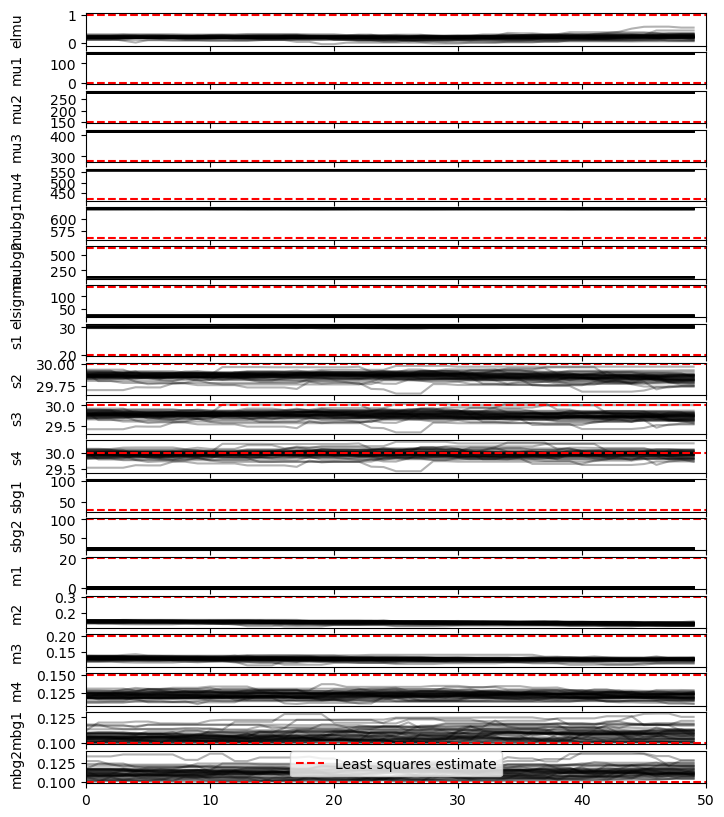

In [15]:
cpo.plot_MCMC_convergences()

## Event-dependent convergence study

In [16]:
assumed_param_values = np.copy(mcparams)

RANDOM_SEED = 1
np.random.seed(seed=RANDOM_SEED)

maxsiz = np.log10(evs.size)
print(evs.size)
print(maxsiz)
evreps=10
n_evs = np.logspace(2, maxsiz, evreps).astype(int)
print(n_evs)
n_evs[-1]=evs.size
print(n_evs)

lse_results = np.zeros((evreps, mcparams.size+1))
lse_errors  = np.zeros((evreps, mcparams.size+1))
mcmc_results = np.zeros((evreps, mcparams.size))
mcmc_errors = np.zeros((evreps, mcparams.size))


lsMinEvents = 10000
mcmcMinEvents = 10
lsMaxEvents = 10000000
mcmcMaxEvents = 90000


rep = 0

for nn in n_evs:
    print("Rep", rep+1, "/", evreps, "|", nn, "/", evs.size)
    print("Subsampling...")
    sse = ema1.subsample(nn)

    sse.lpf = log_prior_function
    sse.pmf = probability_mass_function
    sse.llf = log_likelihood_function


    if nn >= lsMinEvents and nn <= lsMaxEvents:
        print("Least Squares Analysis...")
        sse.least_squares_parameters = copy.deepcopy(lse_starting_parameters)
        sse.calculate_histogram()
        sse.lse_fit()
        #sse.plot_LSE_fit(loglog=False, log=False, xlabel='meV')


        lse_results[rep,:] = sse.get_lse_param_values()
        lse_errors[rep,:] = sse.get_lse_param_errors()
    else:
        print("Skipping Least Squares Analysis (too few events for stable fit)")

    if nn >= mcmcMinEvents and nn <= mcmcMaxEvents:
        print("MCMC Analysis...")
        sse.nwalkers=128 # need to increase this to improve sampling stats quality 
        # (on plots of MCMC_parameter_distribution) 

        sse.theta_seed = same_as_least_squares
        sse.MCMC_fit(nburn=150, niter=150)

        mcmc_results[rep,:], mcmc_errors[rep,:] = sse.get_MCMC_parameters(method='mean')
    else:
        print("Skipping MCMC Analysis (too many events to run on a laptop in sensible time)")

    rep = rep + 1

print("Convergence loop complete.")

5603322
6.748445580312473
[    100     336    1135    3826   12894   43453  146430  493441 1662801
 5603322]
[    100     336    1135    3826   12894   43453  146430  493441 1662801
 5603322]
Rep 1 / 10 | 100 / 5603322
Subsampling...
Skipping Least Squares Analysis (too few events for stable fit)
MCMC Analysis...
MCMC launch
Burn in:


  0%|          | 0/150 [00:00<?, ?it/s]/home/19g/miniforge3/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 150/150 [00:16<00:00,  9.35it/s]


Sampling:


100%|██████████| 150/150 [00:15<00:00,  9.73it/s]


MCMC sampling complete.
stdd 0.10117956897807587
stdd 0.18389832528248565
stdd 0.15665254272772028
stdd 0.13998051414480556
stdd 0.15243135521591666
stdd 0.1532842658449037
stdd 0.10886885430525764
stdd 0.15185201963866565
stdd 0.20829323514856404
stdd 0.08953519242341398
stdd 0.20243728739694938
stdd 0.12219127365873979
stdd 0.08429552097229515
stdd 0.18010448746721922
stdd 0.06300621491220615
stdd 0.040971338690767266
stdd 0.03455798837639776
stdd 0.03348562377032387
stdd 0.024189015221078917
stdd 0.024355285199185783
Rep 2 / 10 | 336 / 5603322
Subsampling...
Skipping Least Squares Analysis (too few events for stable fit)
MCMC Analysis...
MCMC launch
Burn in:


100%|██████████| 150/150 [00:17<00:00,  8.72it/s]


Sampling:


100%|██████████| 150/150 [00:18<00:00,  8.32it/s]


MCMC sampling complete.
stdd 0.1462564512380578
stdd 0.165489394747452
stdd 0.12365054839610769
stdd 0.1507134808792519
stdd 0.1960886702538134
stdd 0.1559760667639794
stdd 0.0891976082833818
stdd 0.16580458341596185
stdd 0.15161321429124505
stdd 0.12244306048349611
stdd 0.11322607080827375
stdd 0.11350862233190823
stdd 0.06660637444745615
stdd 0.13634808757804076
stdd 0.03980979697349037
stdd 0.041843056754174796
stdd 0.02956885574494362
stdd 0.019019338890978496
stdd 0.022817021770819776
stdd 0.0333546180597434
Rep 3 / 10 | 1135 / 5603322
Subsampling...
Skipping Least Squares Analysis (too few events for stable fit)
MCMC Analysis...
MCMC launch
Burn in:


100%|██████████| 150/150 [00:22<00:00,  6.62it/s]


Sampling:


100%|██████████| 150/150 [00:23<00:00,  6.47it/s]


MCMC sampling complete.
stdd 0.11277238368924367
stdd 0.21713879250531748
stdd 0.31504487381404794
stdd 0.17423582952489025
stdd 0.3417265698055262
stdd 0.1485568043992917
stdd 0.24078292633090476
stdd 0.26325083852109066
stdd 0.39011258747047545
stdd 0.18527895156840382
stdd 0.2873712654371667
stdd 0.3793159323054631
stdd 0.1278105364605076
stdd 0.2819955999323372
stdd 0.023986393435057343
stdd 0.019778537503088008
stdd 0.01780836725817419
stdd 0.016805450026098845
stdd 0.01163751188722992
stdd 0.014785174676615317
Rep 4 / 10 | 3826 / 5603322
Subsampling...
Skipping Least Squares Analysis (too few events for stable fit)
MCMC Analysis...
MCMC launch
Burn in:


100%|██████████| 150/150 [00:36<00:00,  4.16it/s]


Sampling:


100%|██████████| 150/150 [00:34<00:00,  4.36it/s]


MCMC sampling complete.
stdd 0.3674799895267527
stdd 0.2067753313722246
stdd 0.10444249171244468
stdd 0.08870463798419327
stdd 0.15267679967633332
stdd 0.3604245738425928
stdd 0.31911901275312554
stdd 0.22746807734356642
stdd 0.12275290675215556
stdd 0.16386669395299827
stdd 0.2862192747748142
stdd 0.18763420295084057
stdd 0.06836725051917458
stdd 0.1333914501150964
stdd 0.011968088916630884
stdd 0.009206562686783657
stdd 0.0104855263138419
stdd 0.010234687680711776
stdd 0.008179916035197465
stdd 0.008738193707156273
Rep 5 / 10 | 12894 / 5603322
Subsampling...
Least Squares Analysis...
MCMC Analysis...
MCMC launch
Burn in:


100%|██████████| 150/150 [01:14<00:00,  2.02it/s]


Sampling:


100%|██████████| 150/150 [01:16<00:00,  1.97it/s]


MCMC sampling complete.
stdd 0.4310237186462602
stdd 0.7014085638432295
stdd 0.20464433028041648
stdd 0.44015012188441366
stdd 0.5682663835539442
stdd 0.26163570284763066
stdd 0.3912554159668943
stdd 0.44244060356796927
stdd 0.24138227014129618
stdd 0.6881082896823297
stdd 0.18979895336135852
stdd 0.27570950906173725
stdd 0.027492208337698547
stdd 0.3485941712281613
stdd 0.007746269301777915
stdd 0.004067754506279492
stdd 0.005770895533965198
stdd 0.006376439388681733
stdd 0.006749658183553037
stdd 0.00650080326953833
Rep 6 / 10 | 43453 / 5603322
Subsampling...
Least Squares Analysis...
MCMC Analysis...
MCMC launch
Burn in:


100%|██████████| 150/150 [03:41<00:00,  1.47s/it]


Sampling:


100%|██████████| 150/150 [04:04<00:00,  1.63s/it]


MCMC sampling complete.
stdd 0.8683913838697137
stdd 0.4150469229734901
stdd 0.7352977321036669
stdd 0.8406082063385901
stdd 1.7069654809698231
stdd 0.6371769481076974
stdd 0.46912188535563265
stdd 0.8252583213529946
stdd 1.5668089683015949
stdd 1.4938807742923208
stdd 0.725472541559879
stdd 1.191778309250909
stdd 0.42756703591180245
stdd 0.6006740190124015
stdd 0.009563323904756489
stdd 0.004162153901731064
stdd 0.006112769411532275
stdd 0.0052872160548250455
stdd 0.005359933827506965
stdd 0.006853042830818548
Rep 7 / 10 | 146430 / 5603322
Subsampling...
Least Squares Analysis...
Skipping MCMC Analysis (too many events to run on a laptop in sensible time)
Rep 8 / 10 | 493441 / 5603322
Subsampling...
Least Squares Analysis...
Skipping MCMC Analysis (too many events to run on a laptop in sensible time)
Rep 9 / 10 | 1662801 / 5603322
Subsampling...
Least Squares Analysis...
Skipping MCMC Analysis (too many events to run on a laptop in sensible time)
Rep 10 / 10 | 5603322 / 5603322
Subsam

In [17]:
assumed_param_values

array([1.24332166e-01, 1.49934442e+02, 2.79894929e+02, 4.19908199e+02,
       5.60050384e+02, 6.19913018e+02, 1.39941270e+02, 2.02674578e+01,
       3.00801751e+01, 2.99041597e+01, 2.98359489e+01, 2.99895793e+01,
       1.00159892e+02, 2.00874672e+01, 3.07972573e-01, 1.55724398e-01,
       1.26510063e-01, 1.20625792e-01, 1.08462896e-01, 1.09087979e-01])

In [18]:
def p_conv_plot(item, param_name='', Bayes=True, LSE=True, savename='', correct=np.inf, ylims=[np.inf, np.inf]):

    # Least squares parameters
    pnams = sse.get_lse_param_names()
    pnam = pnams[item+1]
    
    lsnevs = n_evs
    lsvalues = lse_results[:,item+1]
    lserrs = lse_errors[:,item+1]

    lsmask = lsvalues != 0.0
    lsnevs = lsnevs[lsmask]
    lsvalues = lsvalues[lsmask]
    lserrs = lserrs[lsmask]
    
    lsbtop = lsvalues+lserrs
    lsbbot = lsvalues-lserrs
    lswtop = np.amax(lsvalues)
    lswbot = np.amin(lsvalues)

    # Bayesian parameters
    mcnevs = n_evs
    mcvalues = mcmc_results[:,item]
    mcerrs = mcmc_errors[:,item]

    mcmask = mcvalues != 0.0
    mcvalues = mcvalues[mcmask]
    mcerrs = mcerrs[mcmask]
    mcnevs = mcnevs[mcmask]
    
    
    mcbtop = mcvalues+mcerrs
    mcbbot = mcvalues-mcerrs
    mcwtop = np.amax(mcvalues)
    mcwbot = np.amin(mcvalues)
    
    
    wtop = np.amax([lswtop, mcwtop])
    wbot = np.amin([lswbot, mcwbot])

    wspan = wtop - wbot
    wpad = wspan * 0.1
    wtop = wtop + np.abs(wpad)
    wbot = wbot - np.abs(wpad)

        
    fig, ax = plt.subplots()
    if LSE:
        ax.plot(lsnevs, lsvalues, color='blue', label='LSE')
        ax.fill_between(lsnevs, lsbbot, lsbtop, color='blue', alpha=0.15, label='LSE std. err')
        ax.set_ylim([wbot, wtop])
        ax.set_xlabel("# events")
        ax.set_ylabel(pnam + "Value")
        if param_name != '':
            ax.set_ylabel(param_name)

    if Bayes:
        ax.plot(mcnevs, mcvalues, color='red', label='Bayes')
        ax.fill_between(mcnevs, mcbbot, mcbtop, color='red', alpha=0.15, label='Bayes std. err')

    if np.isfinite(correct):
        xmin=np.amin(mcnevs)
        xmax=np.amax(lsnevs)
        plt.hlines(correct, xmin, xmax, label='Visual estimate', ls='--', color='orange')


    if np.isfinite(ylims).all():
        plt.ylim(ylims)
    
    
    plt.xscale('log')
    plt.yscale('linear')
    ax.legend()

        

    if savename != '':
        plt.savefig(savename, dpi=600, bbox_inches='tight')
        plt.show()
    
    #print(sse.get_lse_param_names())

    

### Elastic Line Parameters

What are the correct values?  lets inspect the kde of the full data set.

Calculating KDE
   - linear scale
nx 174
slice size 0.45712214006696433


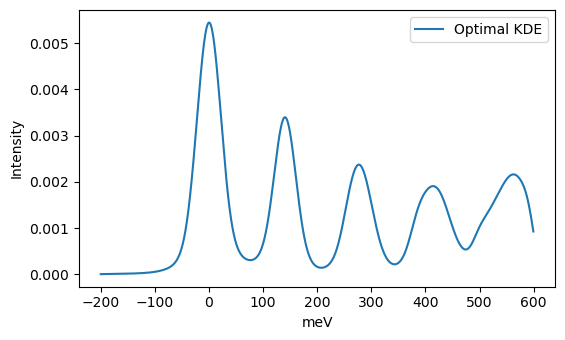

In [19]:
ema1.plot_kde(loglog=False,log=False, xlabel='meV', method='silverman')

<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1458442/2606234182.py:13: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta$E (meV)')
/tmp/ipykernel_1458442/2606234182.py:17: SyntaxWarning: invalid escape sequence '\m'
  ax.text(mu+1, ht*0.8, "$\mu$=" + str(mu))
/tmp/ipykernel_1458442/2606234182.py:18: SyntaxWarning: invalid escape sequence '\s'
  ax.text(mu+4, ht*0.53, "$\sigma$=" + str(sig))


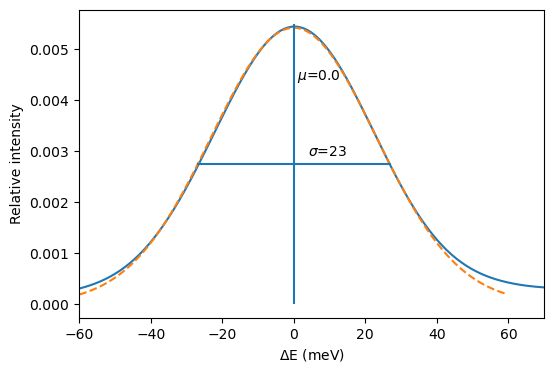

In [20]:


mu=0.0
sig=23
norm=3.2
ht=0.0055

px=np.arange(-60,60,1)
nrm = sp.stats.norm(loc=mu,scale=sig)
py=nrm.pdf(px)/norm

fig,ax=plt.subplots()
plt.plot(ema1.kdex, ema1.kdey)
plt.plot(px, py, ls='--')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
plt.vlines(mu, 0.0, ht)
plt.hlines(ht/2.0, mu-2.355*sig/2.0, mu+2.355*sig/2.0)
ax.text(mu+1, ht*0.8, "$\mu$=" + str(mu))
ax.text(mu+4, ht*0.53, "$\sigma$=" + str(sig))
fig.set_size_inches(6,4)
plt.xlim([-60,70])
plt.savefig('arcsFigs/arcs_fulldata_kde_elastic.png', dpi=600, bbox_inches='tight')
plt.show()

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1458442/370812534.py:2: SyntaxWarning: invalid escape sequence '\m'
  p_conv_plot(parameter_no, param_name='Elastic Line $\mu$ (meV)', savename='arcsFigs/arcs_elastic_mu.png', correct=0.0)


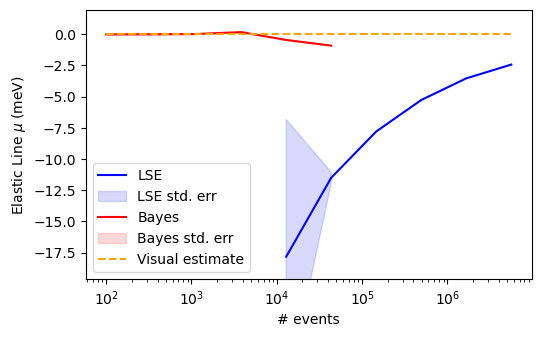

In [21]:
parameter_no = 0
p_conv_plot(parameter_no, param_name='Elastic Line $\mu$ (meV)', savename='arcsFigs/arcs_elastic_mu.png', correct=0.0)
#p_conv_plot(parameter_no, LSE=False)

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1458442/3210244978.py:2: SyntaxWarning: invalid escape sequence '\s'
  p_conv_plot(parameter_no, param_name='Elastic $\sigma$ (meV)', savename='arcsFigs/arcs_elastic_sigma.png', correct=23, ylims=[9, 26])


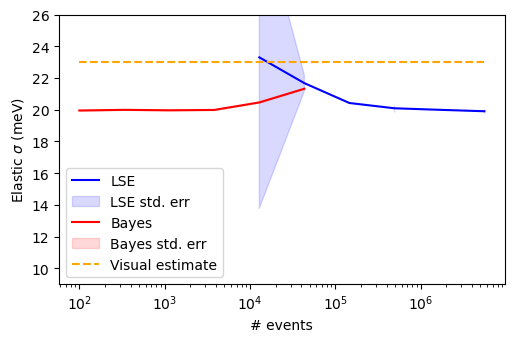

In [22]:
parameter_no = 7
p_conv_plot(parameter_no, param_name='Elastic $\sigma$ (meV)', savename='arcsFigs/arcs_elastic_sigma.png', correct=23, ylims=[9, 26])
#p_conv_plot(parameter_no, LSE=False)

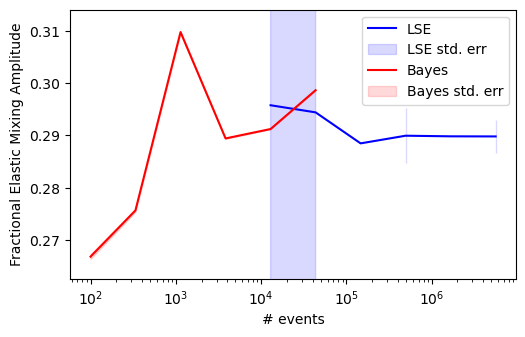

In [23]:
parameter_no = 14
p_conv_plot(parameter_no, param_name='Fractional Elastic Mixing Amplitude', savename='arcsFigs/arcs_elastic_amplitude.png')
#p_conv_plot(parameter_no, LSE=False)

### First Excitation Line Parameters

<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1458442/1224471436.py:13: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta$E (meV)')
/tmp/ipykernel_1458442/1224471436.py:17: SyntaxWarning: invalid escape sequence '\m'
  ax.text(mu+1, ht*0.8, "$\mu$=" + str(mu))
/tmp/ipykernel_1458442/1224471436.py:18: SyntaxWarning: invalid escape sequence '\s'
  ax.text(mu+4, ht*0.53, "$\sigma$=" + str(sig))


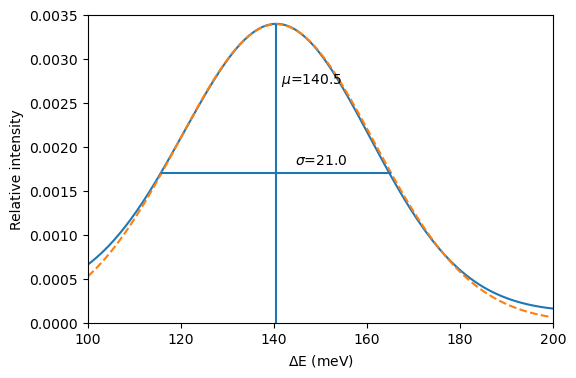

In [24]:
mu=140.5
sig=21.0
norm=5.6
ht=0.0034

px=np.arange(100,200,1)
nrm = sp.stats.norm(loc=mu,scale=sig)
py=nrm.pdf(px)/norm

fig,ax=plt.subplots()
plt.plot(ema1.kdex, ema1.kdey)
plt.plot(px, py, ls='--')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
plt.vlines(mu, 0.0, ht)
plt.hlines(ht/2.0, mu-2.355*sig/2.0, mu+2.355*sig/2.0)
ax.text(mu+1, ht*0.8, "$\mu$=" + str(mu))
ax.text(mu+4, ht*0.53, "$\sigma$=" + str(sig))
fig.set_size_inches(6,4)
plt.xlim([100,200])
plt.ylim([0.0, 0.0035])
plt.savefig('arcsFigs/arcs_fulldata_kde_ex1.png', dpi=600, bbox_inches='tight')
plt.show()

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1458442/642471472.py:2: SyntaxWarning: invalid escape sequence '\m'
  p_conv_plot(parameter_no, param_name='Ex1 $\mu$ (meV)', savename='arcsFigs/arcs_ex1_mu.png', correct=140.5)


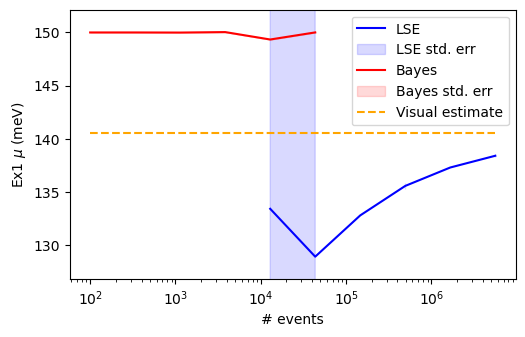

In [25]:
parameter_no = 1
p_conv_plot(parameter_no, param_name='Ex1 $\mu$ (meV)', savename='arcsFigs/arcs_ex1_mu.png', correct=140.5)
#p_conv_plot(parameter_no, LSE=False)

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1458442/4058472112.py:2: SyntaxWarning: invalid escape sequence '\s'
  p_conv_plot(parameter_no, param_name='Ex1 $\sigma$ (meV)', savename='arcsFigs/arcs_ex1_sigma.png', correct=21)


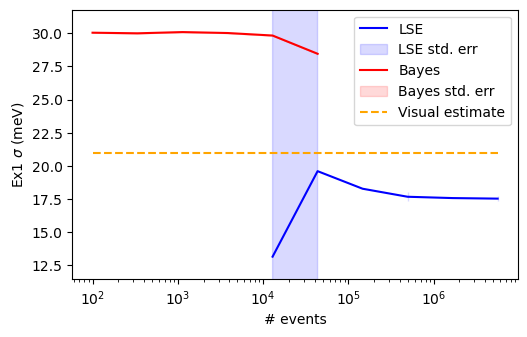

In [26]:
parameter_no = 8
p_conv_plot(parameter_no, param_name='Ex1 $\sigma$ (meV)', savename='arcsFigs/arcs_ex1_sigma.png', correct=21)
#p_conv_plot(parameter_no, LSE=False)

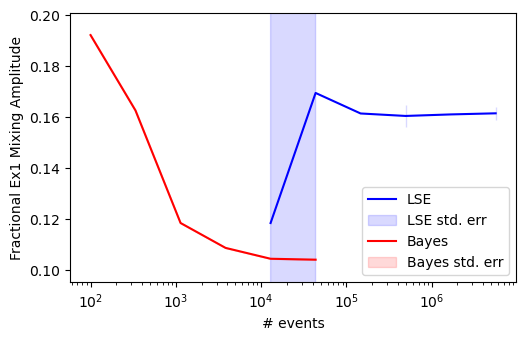

In [27]:
parameter_no = 15
p_conv_plot(parameter_no, param_name='Fractional Ex1 Mixing Amplitude', savename='arcsFigs/arcs_ex1_amplitude.png')
#p_conv_plot(parameter_no, LSE=False)

### Second Excitation Line Parameters

<>:16: SyntaxWarning: invalid escape sequence '\D'
<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\D'
<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1458442/1744288277.py:16: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta$E (meV)')
/tmp/ipykernel_1458442/1744288277.py:20: SyntaxWarning: invalid escape sequence '\m'
  ax.text(mu+1, ht*0.8, "$\mu$=" + str(mu))
/tmp/ipykernel_1458442/1744288277.py:21: SyntaxWarning: invalid escape sequence '\s'
  ax.text(mu+4, ht*0.53, "$\sigma$=" + str(sig))


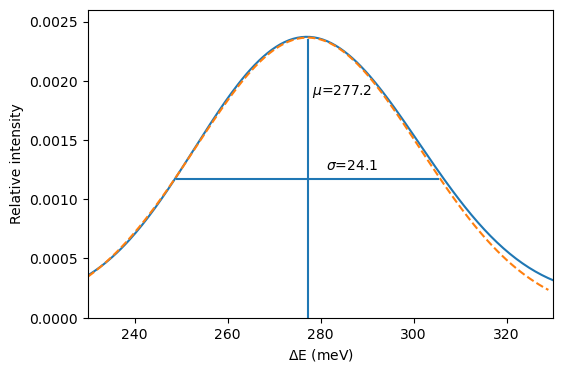

In [28]:
mu=277.2
sig=24.1
norm= 7.0
ht=0.00235

r1=230
r2=330

px=np.arange(r1,r2,1)
nrm = sp.stats.norm(loc=mu,scale=sig)
py=nrm.pdf(px)/norm

fig,ax=plt.subplots()
plt.plot(ema1.kdex, ema1.kdey)
plt.plot(px, py, ls='--')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
plt.vlines(mu, 0.0, ht)
plt.hlines(ht/2.0, mu-2.355*sig/2.0, mu+2.355*sig/2.0)
ax.text(mu+1, ht*0.8, "$\mu$=" + str(mu))
ax.text(mu+4, ht*0.53, "$\sigma$=" + str(sig))
fig.set_size_inches(6,4)
plt.xlim([r1,r2])
plt.ylim([0.0, 0.0026])
plt.savefig('arcsFigs/arcs_fulldata_kde_ex2.png', dpi=600, bbox_inches='tight')
plt.show()

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1458442/1580439841.py:2: SyntaxWarning: invalid escape sequence '\m'
  p_conv_plot(parameter_no, param_name='Ex2 $\mu$ (meV)', savename='arcsFigs/arcs_ex2_mu.png', correct=277.2, ylims=[270, 286])


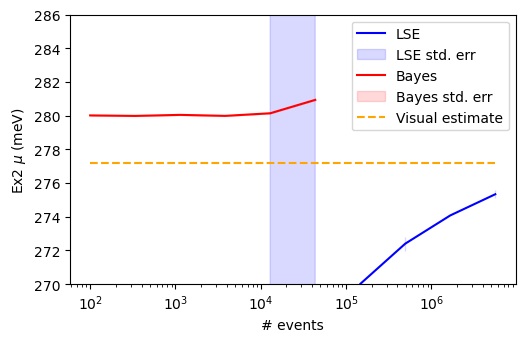

In [29]:
parameter_no = 2
p_conv_plot(parameter_no, param_name='Ex2 $\mu$ (meV)', savename='arcsFigs/arcs_ex2_mu.png', correct=277.2, ylims=[270, 286])
#p_conv_plot(parameter_no, LSE=False)

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1458442/736906144.py:2: SyntaxWarning: invalid escape sequence '\s'
  p_conv_plot(parameter_no, param_name='Ex2 $\sigma$ (meV)', savename='arcsFigs/arcs_ex2_sigma.png', correct=24.1)


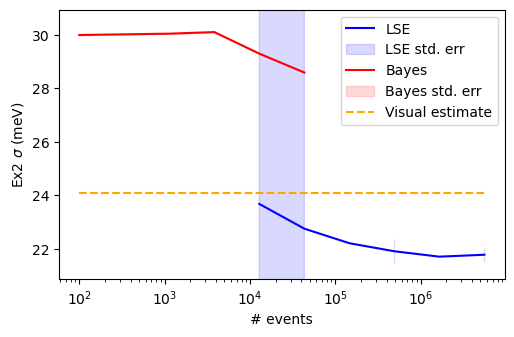

In [30]:
parameter_no = 9
p_conv_plot(parameter_no, param_name='Ex2 $\sigma$ (meV)', savename='arcsFigs/arcs_ex2_sigma.png', correct=24.1)
#p_conv_plot(parameter_no, LSE=False)

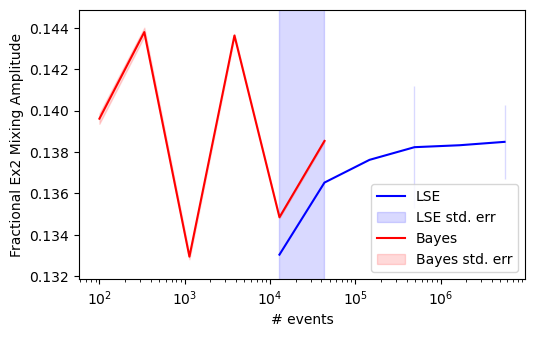

In [31]:
parameter_no = 16
p_conv_plot(parameter_no, param_name='Fractional Ex2 Mixing Amplitude', savename='arcsFigs/arcs_ex2_amplitude.png')
#p_conv_plot(parameter_no, LSE=False)

### Third Excitation Line Parameters

<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1458442/163644117.py:17: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta$E (meV)')
/tmp/ipykernel_1458442/163644117.py:21: SyntaxWarning: invalid escape sequence '\m'
  ax.text(mu+1, ht*0.8, "$\mu$=" + str(mu))
/tmp/ipykernel_1458442/163644117.py:22: SyntaxWarning: invalid escape sequence '\s'
  ax.text(mu+4, ht*0.53, "$\sigma$=" + str(sig))


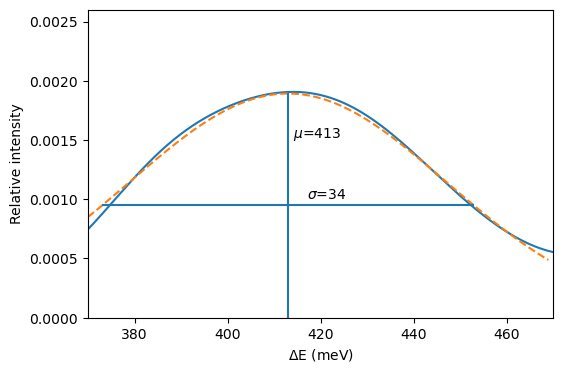

In [32]:
window_mu=420.0
mu=413
sig=34
norm=6.2
ht=0.0019

r1=window_mu-50
r2=window_mu+50

px=np.arange(r1,r2,1)
nrm = sp.stats.norm(loc=mu,scale=sig)
py=nrm.pdf(px)/norm

fig,ax=plt.subplots()
plt.plot(ema1.kdex, ema1.kdey)
plt.plot(px, py, ls='--')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
plt.vlines(mu, 0.0, ht)
plt.hlines(ht/2.0, mu-2.355*sig/2.0, mu+2.355*sig/2.0)
ax.text(mu+1, ht*0.8, "$\mu$=" + str(mu))
ax.text(mu+4, ht*0.53, "$\sigma$=" + str(sig))
fig.set_size_inches(6,4)
plt.xlim([r1,r2])
plt.ylim([0.0, 0.0026])
plt.savefig('arcsFigs/arcs_fulldata_kde_ex3.png', dpi=600, bbox_inches='tight')
plt.show()

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1458442/690138820.py:2: SyntaxWarning: invalid escape sequence '\m'
  p_conv_plot(parameter_no, param_name='Ex3 $\mu$ (meV)', savename='arcsFigs/arcs_ex3_mu.png', correct=413.0)


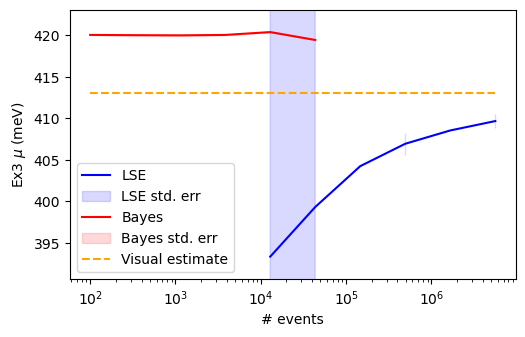

In [33]:
parameter_no = 3
p_conv_plot(parameter_no, param_name='Ex3 $\mu$ (meV)', savename='arcsFigs/arcs_ex3_mu.png', correct=413.0)
#p_conv_plot(parameter_no, LSE=False)

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1458442/1254865847.py:2: SyntaxWarning: invalid escape sequence '\s'
  p_conv_plot(parameter_no, param_name='Ex3 $\sigma$ (meV)', savename='arcsFigs/arcs_ex3_sigma.png', correct=34.0, ylims=[26, 36])


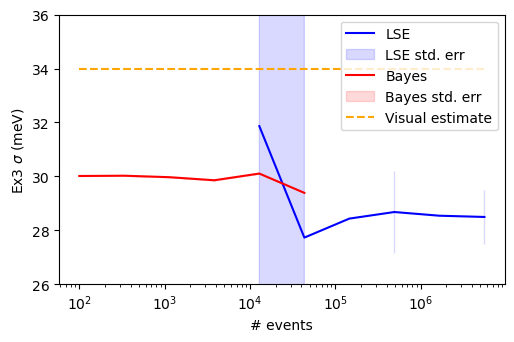

In [34]:
parameter_no = 10
p_conv_plot(parameter_no, param_name='Ex3 $\sigma$ (meV)', savename='arcsFigs/arcs_ex3_sigma.png', correct=34.0, ylims=[26, 36])
#p_conv_plot(parameter_no, LSE=False)

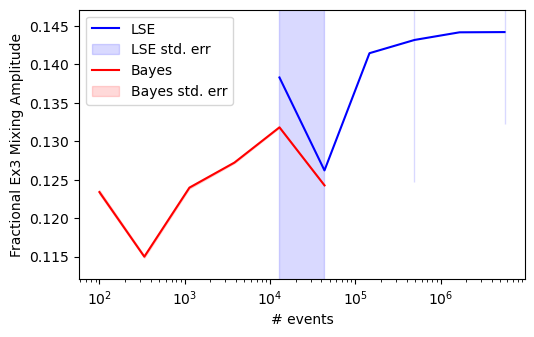

In [35]:
parameter_no = 17
p_conv_plot(parameter_no, param_name='Fractional Ex3 Mixing Amplitude', savename='arcsFigs/arcs_ex3_amplitude.png')
#p_conv_plot(parameter_no, LSE=False)

### Fourth Excitation Line Parameters

<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1458442/3018487124.py:17: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta$E (meV)')
/tmp/ipykernel_1458442/3018487124.py:21: SyntaxWarning: invalid escape sequence '\m'
  ax.text(mu+1, ht*0.8, "$\mu$=" + str(mu))
/tmp/ipykernel_1458442/3018487124.py:22: SyntaxWarning: invalid escape sequence '\s'
  ax.text(mu+4, ht*0.53, "$\sigma$=" + str(sig))


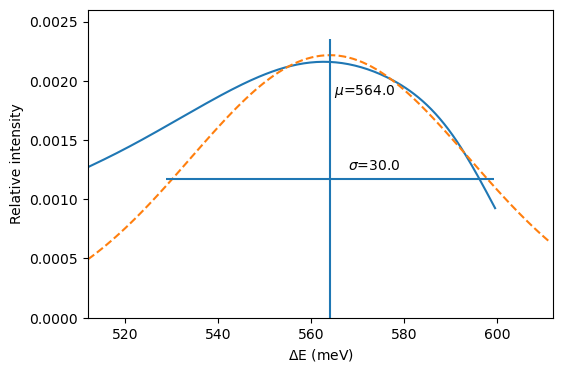

In [36]:
window_mu=562.0
mu=window_mu+2
sig=30.0
norm=6
ht=0.00235

r1=window_mu-50
r2=window_mu+50

px=np.arange(r1,r2,1)
nrm = sp.stats.norm(loc=mu,scale=sig)
py=nrm.pdf(px)/norm

fig,ax=plt.subplots()
plt.plot(ema1.kdex, ema1.kdey)
plt.plot(px, py, ls='--')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
plt.vlines(mu, 0.0, ht)
plt.hlines(ht/2.0, mu-2.355*sig/2.0, mu+2.355*sig/2.0)
ax.text(mu+1, ht*0.8, "$\mu$=" + str(mu))
ax.text(mu+4, ht*0.53, "$\sigma$=" + str(sig))
fig.set_size_inches(6,4)
plt.xlim([r1,r2])
plt.ylim([0.0, 0.0026])
plt.savefig('arcsFigs/arcs_fulldata_kde_ex4.png', dpi=600, bbox_inches='tight')
plt.show()

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1458442/3265296626.py:2: SyntaxWarning: invalid escape sequence '\m'
  p_conv_plot(parameter_no, param_name='Ex4 $\mu$ (meV)', savename='arcsFigs/arcs_ex4_mu.png', correct=564.0, ylims=[550, 570])


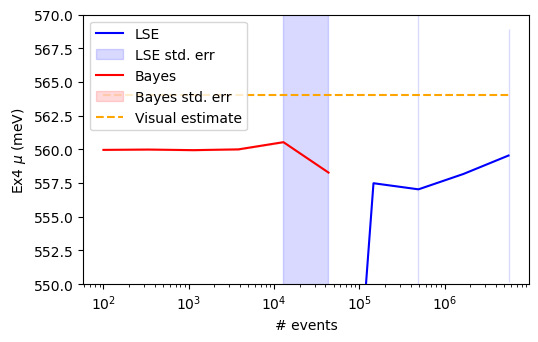

In [37]:
parameter_no = 4
p_conv_plot(parameter_no, param_name='Ex4 $\mu$ (meV)', savename='arcsFigs/arcs_ex4_mu.png', correct=564.0, ylims=[550, 570])
#p_conv_plot(parameter_no, LSE=False)

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1458442/391605544.py:2: SyntaxWarning: invalid escape sequence '\s'
  p_conv_plot(parameter_no, param_name='Ex4 $\sigma$ (meV)', savename='arcsFigs/arcs_ex4_sigma.png')


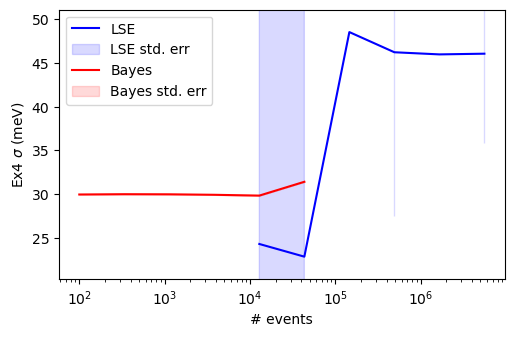

In [38]:
parameter_no = 11
p_conv_plot(parameter_no, param_name='Ex4 $\sigma$ (meV)', savename='arcsFigs/arcs_ex4_sigma.png')
#p_conv_plot(parameter_no, LSE=False)

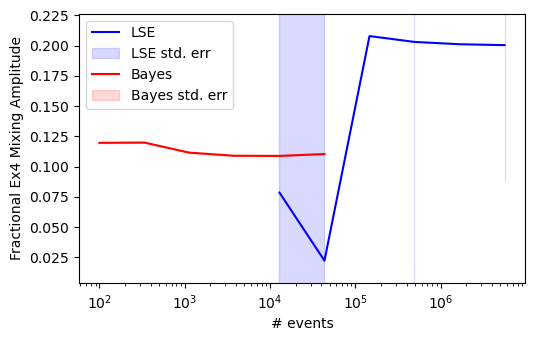

In [39]:
parameter_no = 18
p_conv_plot(parameter_no, param_name='Fractional Ex4 Mixing Amplitude', savename='arcsFigs/arcs_ex4_amplitude.png')
#p_conv_plot(parameter_no, LSE=False)

### First Background Term Parameters 

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1458442/2621897157.py:2: SyntaxWarning: invalid escape sequence '\m'
  p_conv_plot(parameter_no, param_name='BG1 $\mu$ (meV)', savename='arcsFigs/arcs_BG1_mu.png')


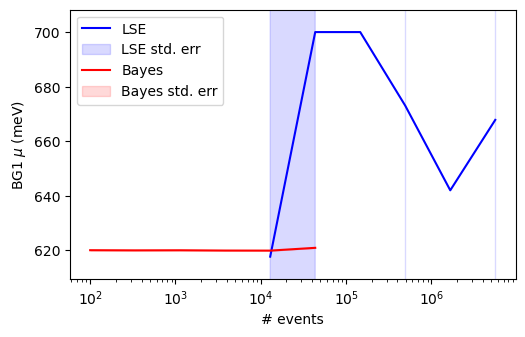

In [40]:
parameter_no = 5
p_conv_plot(parameter_no, param_name='BG1 $\mu$ (meV)', savename='arcsFigs/arcs_BG1_mu.png')
#p_conv_plot(parameter_no, LSE=False)

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1458442/2793790839.py:2: SyntaxWarning: invalid escape sequence '\s'
  p_conv_plot(parameter_no, param_name='BG1 $\sigma$ (meV)', savename='arcsFigs/arcs_BG1_sigma.png')


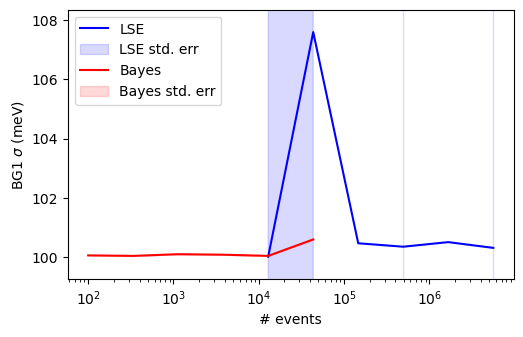

In [41]:
parameter_no = 12
p_conv_plot(parameter_no, param_name='BG1 $\sigma$ (meV)', savename='arcsFigs/arcs_BG1_sigma.png')
#p_conv_plot(parameter_no, LSE=False)

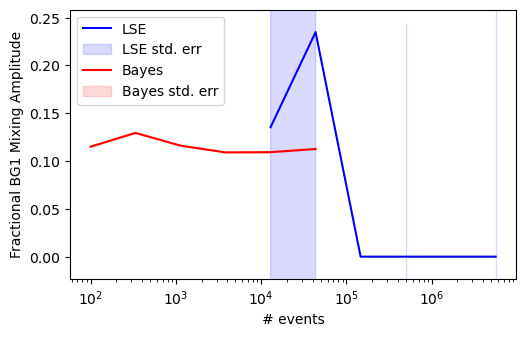

In [42]:
parameter_no = 19
p_conv_plot(parameter_no, param_name='Fractional BG1 Mixing Amplitude', savename='arcsFigs/arcs_BG1_amplitude.png')
#p_conv_plot(parameter_no, LSE=False)

### Second Background Term Parameters

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1458442/2602758869.py:2: SyntaxWarning: invalid escape sequence '\m'
  p_conv_plot(parameter_no, param_name='BG2 $\mu$ (meV)', savename='arcsFigs/arcs_BG2_mu.png')


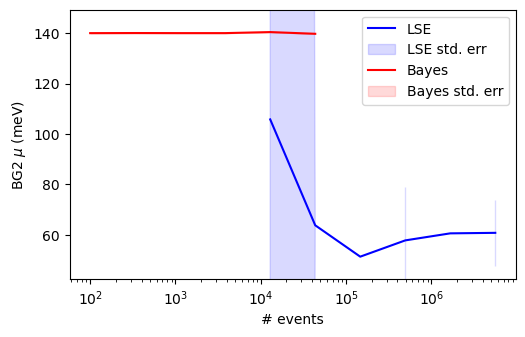

In [43]:
parameter_no = 6
p_conv_plot(parameter_no, param_name='BG2 $\mu$ (meV)', savename='arcsFigs/arcs_BG2_mu.png')
#p_conv_plot(parameter_no, LSE=False)

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1458442/2983440116.py:2: SyntaxWarning: invalid escape sequence '\s'
  p_conv_plot(parameter_no, param_name='BG2 $\sigma$ (meV)', savename='arcsFigs/arcs_BG2_sigma.png')


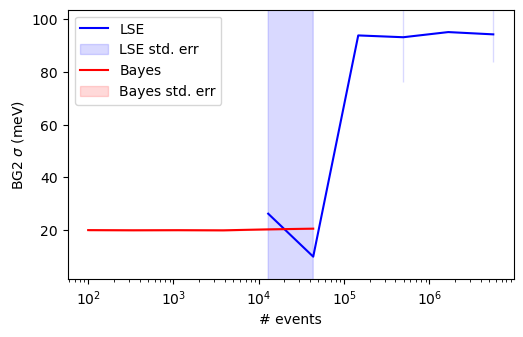

In [44]:
parameter_no = 13
p_conv_plot(parameter_no, param_name='BG2 $\sigma$ (meV)', savename='arcsFigs/arcs_BG2_sigma.png')
#p_conv_plot(parameter_no, LSE=False)

The weight of the second background term is computed from 1-sum(other_weights) so it has no individual parameter.

## Important Questions and Possible Answers

1. Why does the parameter noise obviously exceed the reported variance for the MCMC parameters?

Probably because the random subsample of events is at each step random.  The variance is the *statistical* variance as sampled by MCMC within the data set, whilst the subsampling of the events for low numbers of events provides a systematic shift of that parameter space from analysis to analysis.  The correct variance would probably be obtained by re-subsampling many times and computing the mean and standard error of the obtained parameters.  This is going to be very slow and would require a cluster job in the future to do that work.

2. Why does the variance on some LSE parameters increase with increasing events?

Probably because the LSE is unstable with so many parameters, and it is getting stuck in a local optimum.  If you look at some of the parameters the stated variances for these parameters are enormous, so the LSE estimates from the chi-squared surface curvature are probably wrong.  Since many of the parameter values are so close to those obtained from MCMC I suspect that monte-carlo sampling the LSE parameter space as described above might yield more realistic parameter variances.
